# Tracking the Evolution of Irregular Satellites

Here, we initialize some randomly-distributed satellites around a planet, filling its Hill sphere, and study which ones remain stable over long timescales.

In [125]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

In [58]:
np.random.seed(50)

# details about star and planet
m_star = 1
m_planet = 1e-3
a_planet = 5.2
e_planet = 0.05

# defining the Hill radius
r_Hill = a_planet*(1 - e_planet) * (m_planet / (3*m_star))**(1/3)

For easy initialization (using orbital elements) we'll initialize the satellites with the planet as their main body.  For easier viewing, we treat the planet as the 'primary' particle of the entire simulation, and let the star orbit around *it*. We give the satellites a range of possible semimajor axes and inclinations, but keep them all circular.

In [59]:
# details about satellites
num_sats = 100

a_sats = np.random.uniform(.1*r_Hill, r_Hill, num_sats)    # a ranges from .1*r_Hill to r_Hill (au)
i_sats = np.random.uniform(0, np.pi, num_sats)             # i ranges from 0 to pi (radians) 
om_sats = np.random.uniform(0, 2*np.pi, num_sats)          # omega ranges from 0 to 2 pi (radians)

In [60]:
sim = rebound.Simulation()

# add planet
sim.add(m=m_planet, hash='planet')

# add satellites around planet
for i in range(num_sats):
    sim.add(m=0, a=a_sats[i], inc=i_sats[i], omega=om_sats[i], primary='planet')
    # note that we set m = 0 -- these will be test particles, so they won't interact with each other
    
# add star "orbiting" planet
sim.add(m=m_star, a=a_planet, e=e_planet, hash='star')

In [61]:
# setting up fast integration
sim.integrator='whfast'
sim.dt=0.5

We now integrate over time, using a maximum time of $10^4$ yr with 1000 timesteps as an example.

In [62]:
maxTime = 1e4
steps = 1000

times = np.linspace(0., maxTime, steps)
a_data = np.zeros((steps,num_sats))
e_data = np.zeros((steps,num_sats))
i_data = np.zeros((steps,num_sats))
ps = sim.particles

for i, time in enumerate(times):
    sim.integrate(time)

    for moon in range(num_sats):
        a_data[i,moon] = ps[moon + 1].a
        e_data[i,moon] = ps[moon + 1].e
        i_data[i,moon] = ps[moon + 1].inc

sim.status()

---------------------------------
REBOUND version:     	3.24.0
REBOUND built on:    	Mar 29 2023 22:01:16
Number of particles: 	102
Selected integrator: 	whfast
Simulation time:     	1.0000000000000000e+04
Current timestep:    	0.500000
---------------------------------
<rebound.particle.Particle object at 0x138dcb240, m=0.001 x=6.615643210710166 y=4603.027204802242 z=0.0 vx=0.4159088312815286 vy=0.5789192184885301 vz=0.0>
<rebound.particle.Particle object at 0x138dda840, m=0.0 x=-2.2534732626254037 y=4594.71065747586 z=-0.249976835025393 vx=0.18183506860171822 vy=0.39332281071230124 vz=0.0017080191815130531>
<rebound.particle.Particle object at 0x138dcb240, m=0.0 x=6.645205696596155 y=4603.000505754713 z=-0.11137684987449568 vx=0.4979662311392743 vy=0.5640664693072944 vz=0.01980608137297039>
<rebound.particle.Particle object at 0x138dda840, m=0.0 x=6.476707438276494 y=4603.043582595433 z=-0.0441080419674367 vx=0.40525988354055986 vy=0.5542276525056071 vz=0.06670487809811866>
<rebound.

We can now plot the changes in semi-major axis, eccentricity, and inclination of any satellite over time. An example of this (chosen at random) is shown below.

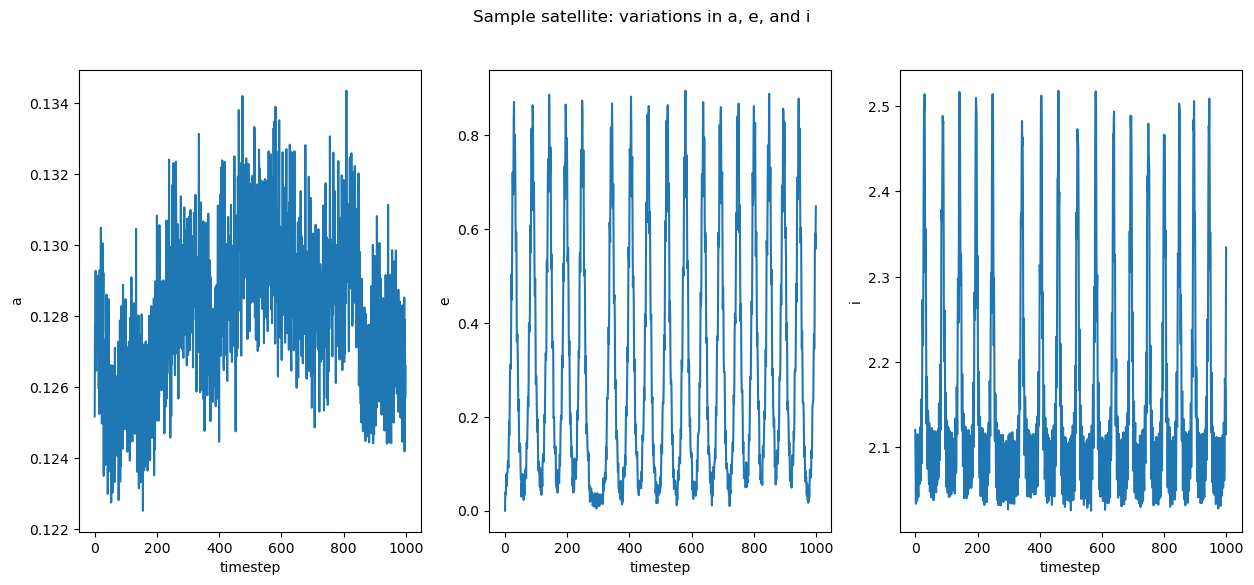

In [127]:
fig, ax = plt.subplots(1,3,figsize=(15,6))
plt.suptitle('Sample satellite: variations in a, e, and i')

# semi-major axis plot
plt.subplot(1,3,1)
plt.plot(a_data[:,50])
plt.ylabel('a')
plt.xlabel('timestep')

# eccentricity plot
plt.subplot(1,3,2)
plt.plot(e_data[:,50])
plt.ylabel('e')
plt.xlabel('timestep')

# inclination plot
plt.subplot(1,3,3)
plt.plot(i_data[:,50])
plt.ylabel('i')
plt.xlabel('timestep')

plt.show()

Some satellites clearly become unstable, which we can plot against initial conditions to see if any sort of pattern emerges. We evaluate instability criteria as the satellite having a semi-major axis < 0 (which is non-physical) at any point. It is interesting to note that the stability of each satellite appears to be dominated by its initial semi-major axis!

In [75]:
# creating boolean for each satellite representing whether it becomes unstable
sat_unstable = [(min(a_data[:,s]) < 0) for s in range(0,num_sats)]

# creating arrays of initial conditions for a, e, and i
sat_init_a = a_data[0,:]
sat_init_e = e_data[0,:]
sat_init_i = i_data[0,:]

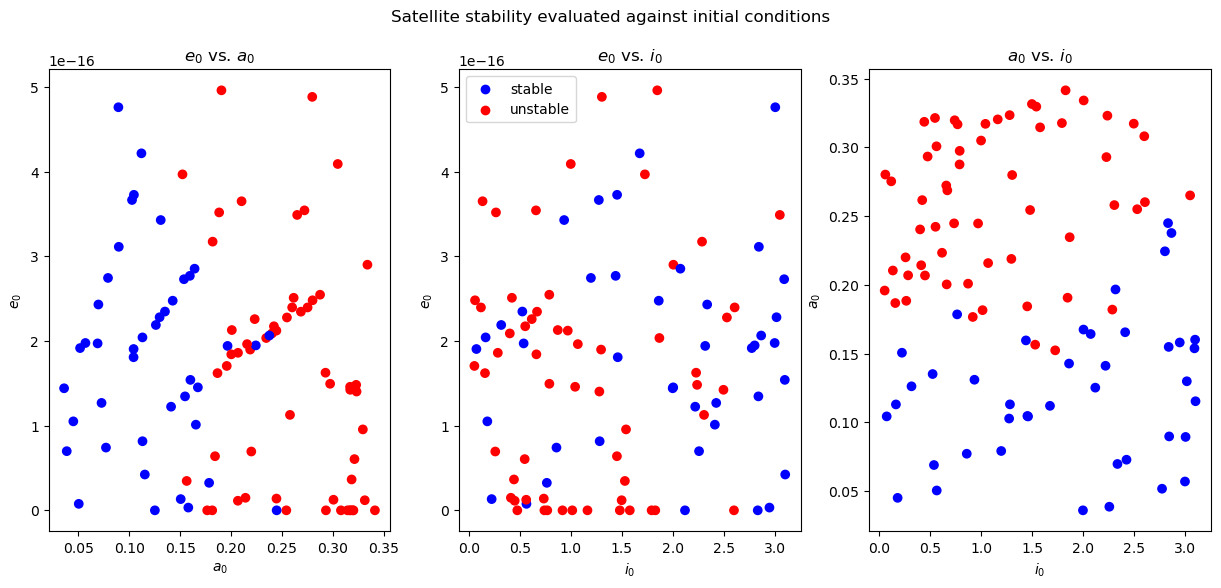

In [134]:
# plotting stability in the context of initial conditions
fig, ax = plt.subplots(1,3,figsize=(15,6))
plt.suptitle('Satellite stability evaluated against initial conditions')
colours = ['red' if u else 'blue' for u in sat_unstable]

# e vs. a
plt.subplot(1,3,1)
sats = plt.scatter(sat_init_a,sat_init_e,c=colours)
plt.ylabel(r'$e_0$')
plt.xlabel(r'$a_0$')
plt.title(r'$e_0$ vs. $a_0$')

# e vs. i
plt.subplot(1,3,2)
sats = plt.scatter(sat_init_i,sat_init_e,c=colours)
plt.ylabel(r'$e_0$')
plt.xlabel(r'$i_0$')
plt.title(r'$e_0$ vs. $i_0$')

s = plt.scatter(np.nan,np.nan,color='blue')
u = plt.scatter(np.nan,np.nan,color='red')
plt.legend(handles=[s,u],labels=['stable','unstable'])

# a vs. i
plt.subplot(1,3,3)
sats = plt.scatter(sat_init_i,sat_init_a,c=colours)
plt.ylabel(r'$a_0$')
plt.xlabel(r'$i_0$')
plt.title(r'$a_0$ vs. $i_0$')

plt.show()

We now have our setup! We can visualize the irregular satellites in three dimensions by zooming in on the planet in $\texttt{OrbitPlotSet}$.

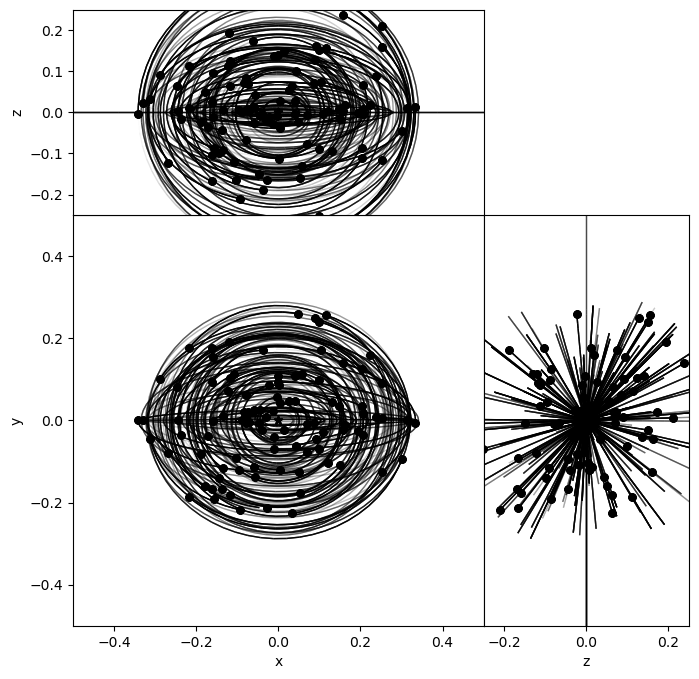

In [5]:
fig = rebound.OrbitPlotSet(sim, xlim=[-.5,.5], ylim=[-.5,.5], figsize=(8,8))

Next steps:
- Integrate over some amount of time
- See which satellites leave the Hill sphere
- Make some pretty plots
- Maybe add in a sudden change in stellar mass?